In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2022-05-09 23:00:52


In [2]:
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import itertools
import folium
import os
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
dirs = 'Outputs'
if not os.path.exists(dirs):
    os.makedirs(dirs)

# Part 2: Spatial Interaction models

In [4]:
london_flows = pd.read_csv('london_flows.csv')

In [5]:
london_flows.head(5)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [6]:
london_flows.describe()

,flows,population,jobs,distance
count,61474.000000,61474.000000,61474.000000,61474.000000
mean,25.090136,5532.198311,6136.424797,16314.843326
std,131.416761,8509.601663,10916.883647,9401.466907
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1554.000000,792.000000,8939.809178
50%,3.000000,2839.000000,1921.000000,15232.813073
75%,13.000000,5389.000000,6295.000000,22283.826198
max,15946.000000,67372.000000,78549.000000,60633.323742


In [7]:
print(london_flows['flows'].sum(),london_flows['population'].sum(),london_flows['jobs'].sum())

1542391 340086359 377230578


Where ***population*** refers to the total number of populations who use the *station_origin* to commute; ***jobs*** refers to the jobs provided around the location of *station_destination*; ***flows*** refers to the actual flows of communication from *station_origin* to *station_destination*, the sum of *flows* for each origin should equal to the *population* of each origin.

## Pre-process

In [8]:
# would be better if rename the columns
ODflows_df=london_flows.rename(columns={'station_origin':'Orig','station_destination':'Dest','population':'Oi_pop','jobs':'Dj_jobs'})

In [9]:
ODflows_df.isnull().sum()

Orig        0
Dest        0
flows       0
Oi_pop      0
Dj_jobs     0
distance    0
dtype: int64

No `Nan` data, good.

It was found that few records of incorrectly recorded in the raw dataset where flows should not have existed in the pair of orig and dest at the same station.

In [10]:
abnormal_flows = 0
list_rows=[]
for row in range(len(ODflows_df)):
    if ODflows_df['Orig'][row]==ODflows_df['Dest'][row]:
        abnormal_flows=abnormal_flows+ODflows_df['flows'][row]
        list_rows.append(row)
        print('Abnormal records:',ODflows_df['Orig'][row],ODflows_df['Dest'][row],ODflows_df['flows'][row])
print('Total value of abnormal flows',abnormal_flows)

Abnormal records: Blackfriars Blackfriars 1
Abnormal records: Canary Wharf Canary Wharf 0
Abnormal records: Cannon Street Cannon Street 0
Abnormal records: Elephant & Castle Elephant & Castle 0
Abnormal records: Euston Euston 0
Abnormal records: Euston Square Euston Square 0
Abnormal records: Finsbury Park Finsbury Park 0
Abnormal records: Hackney Central Hackney Central 0
Abnormal records: Hackney Downs Hackney Downs 1
Abnormal records: Hammersmith Hammersmith 0
Abnormal records: Limehouse Limehouse 38
Abnormal records: Liverpool Street Liverpool Street 0
Abnormal records: London Bridge London Bridge 4
Abnormal records: Paddington Paddington 5
Abnormal records: Shadwell Shadwell 1
Abnormal records: Shepherd's Bush Shepherd's Bush 0
Abnormal records: Victoria Victoria 0
Abnormal records: Waterloo Waterloo 58
Total value of abnormal flows 108


In [11]:
OD_flows=ODflows_df.drop(list_rows,axis=0)

In [12]:
OD_flows

,Orig,Dest,flows,Oi_pop,Dj_jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [13]:
print(len(OD_flows['Orig'].unique()),len(OD_flows['Dest'].unique()))

399 399


In [14]:
OD_flows.groupby(by=["Orig"]).agg({'Dest':['count']}).describe()

,Dest
,count
count,399.000000
mean,154.025063
std,91.034945
min,2.000000
25%,44.000000
50%,174.000000
75%,233.500000
max,366.000000


In this file, number of destinations for each origin is differnt. The dataset is not completed which may generate to a lot of `NaNs` if applied pivot table.

## Models and calibration

Model selected

In [15]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

In [16]:
ptable_flows = OD_flows.pivot_table(values ="flows", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
ptable_flows

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


## The Origin- Constrained Model

With these parameters, the inverse power function has a far more rapid distance decay effect than the negative exponential function.

In the case of daily communication where observed flows would drop off very rapidly with distance, the distance decay here might be more likely to follow an inverse power $c_{ij}^{-\beta}$.

\begin{equation} \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \tag{2}
O_i = \sum_j T_{ij}
\end{equation}

and

\begin{equation} \tag{3}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{4}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In [17]:
# Before log, replace zero as 0.000001. Otherwise, errors may occur
OD_flows['Oi_pop']=OD_flows['Oi_pop'].replace(0,0.000001)
OD_flows['Dj_jobs']=OD_flows['Dj_jobs'].replace(0,0.000001)

In [18]:
OD_flows['log_Oi_pop'] = np.log(OD_flows['Oi_pop'])
OD_flows['log_Dj_jobs'] = np.log(OD_flows['Dj_jobs'])
OD_flows['log_Dist'] = np.log(OD_flows['distance'])

In [19]:
OD_flows.head(5)

,Orig,Dest,flows,Oi_pop,Dj_jobs,distance,log_Oi_pop,log_Dj_jobs,log_Dist
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,6.395262,9.643939,7.709274


In [20]:
#create the formula (the "-1" indicates no intercept in the regression model).
form_ocm = 'flows ~ Orig + log_Dj_jobs + log_Dist-1'
#run a origin constrained sim
origSim = smf.glm(formula = form_ocm, data=OD_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(origSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    61055
Model Family:                 Poisson   Df Model:                          400
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Mon, 09 May 2022   Deviance:                   1.8615e+06
Time:                        23:02:56   Pearson chi2:                 2.78e+06
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Orig[A

The parameter related to the destination attractiveness: 0.7686

The distance decay parameter: 0.8781

### Model estimates

In [21]:
OD_flows_est = OD_flows.copy()

In [22]:
coefs = pd.DataFrame(origSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(Orig)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
OD_flows_est = OD_flows_est.merge(coefs, left_on="Orig", right_on="coef", how = "left")
OD_flows_est.drop(columns = ["coef"], inplace = True)


/tmp/ipykernel_1253/2447093165.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


In [23]:
origSim.params

Orig[Abbey Road]          3.250242
Orig[Acton Central]       5.016902
Orig[Acton Town]          4.562892
Orig[Aldgate]             3.323767
Orig[Aldgate East]        3.457664
                            ...   
Orig[Woodgrange Park]     5.254667
Orig[Woodside Park]       4.698635
Orig[Woolwich Arsenal]    6.905590
log_Dj_jobs               0.768616
log_Dist                 -0.878119
Length: 401, dtype: float64

In [24]:
alpha_i = origSim.params[0:-2]
gamma = origSim.params[-2]
beta = -origSim.params[-1]
print('gamma:',gamma,'beta:',beta)

gamma: 0.7686156203983159 beta: 0.8781191183572779


In [25]:
OD_flows_est["origsimest1"] = np.exp(OD_flows_est["alpha_i"]+gamma*OD_flows_est["log_Dj_jobs"] 
                                 - beta*OD_flows_est["log_Dist"])

In [26]:
OD_flows_est["origsimest1"] = round(OD_flows_est["origsimest1"],0)
flow_pt_est1 = OD_flows_est.pivot_table(values ="origsimest1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
flow_pt_est1

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [27]:
CalcRSquared(OD_flows_est["flows"], OD_flows_est["origsimest1"])

0.38829196662967197

In [28]:
CalcRMSE(OD_flows_est["flows"], OD_flows_est["origsimest1"])

102.857

In [29]:
print(int(OD_flows_est['flows'].sum()), int(OD_flows_est['origsimest1'].sum()))

1542283 1541806


In [30]:
OD_flows_est

,Orig,Dest,flows,Oi_pop,Dj_jobs,distance,log_Oi_pop,log_Dj_jobs,log_Dist,alpha_i,origsimest1
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,6.395262,11.271478,9.003504,3.250242,55.0
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,6.395262,6.091310,9.049012,3.250242,1.0
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,6.395262,6.499787,8.236275,3.250242,3.0
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348,3.250242,66.0
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,6.395262,9.643939,7.709274,3.250242,49.0
...,...,...,...,...,...,...,...,...,...,...,...
61451,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,8.973605,8.114325,9.503144,6.905590,121.0
61452,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,8.973605,8.610137,9.071245,6.905590,259.0
61453,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,8.973605,5.991465,9.162905,6.905590,32.0
61454,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,8.973605,6.794587,8.585832,6.905590,98.0


## Scenarios

### Scenario A

In [31]:
def job_reduce(row):
    if row["Dest"] == "Canary Wharf":
        val = 0.5*row["Dj_jobs"]
    else:
        val = row["Dj_jobs"]
    return val
        
OD_flows_est["Dj_jobs_scenario_A"] = OD_flows_est.apply(job_reduce, axis =1)
OD_flows_est[OD_flows_est['Dest']=='Canary Wharf']

,Orig,Dest,flows,Oi_pop,Dj_jobs,distance,log_Oi_pop,log_Dj_jobs,log_Dist,alpha_i,origsimest1,Dj_jobs_scenario_A
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348,3.250242,66.0,29386.0
126,Acton Town,Canary Wharf,57,3745.0,58772.0,20398.165882,8.228177,10.981421,9.923200,4.562892,73.0,29386.0
348,Aldgate,Canary Wharf,1,2886.0,58772.0,6564.419680,7.967627,10.981421,8.789419,3.323767,57.0,29386.0
595,Aldgate East,Canary Wharf,3,3172.0,58772.0,5127.998899,8.062118,10.981421,8.542471,3.457664,81.0,29386.0
817,All Saints,Canary Wharf,67,740.0,58772.0,1340.088733,6.606650,10.981421,7.200491,3.380602,244.0,29386.0
...,...,...,...,...,...,...,...,...,...,...,...,...
60577,Wood Green,Canary Wharf,64,6667.0,58772.0,16849.246595,8.804925,10.981421,9.732061,5.137983,153.0,29386.0
60820,Wood Lane,Canary Wharf,0,1088.0,58772.0,17092.091760,6.992096,10.981421,9.746371,3.154679,21.0,29386.0
61044,Woodford,Canary Wharf,192,4868.0,58772.0,13963.787075,8.490438,10.981421,9.544223,5.160643,185.0,29386.0
61276,Woodside Park,Canary Wharf,42,3093.0,58772.0,22356.567178,8.036897,10.981421,10.014875,4.698635,77.0,29386.0


In [32]:
OD_flows_est["origsimestA1"] = np.exp(
    OD_flows_est["alpha_i"]+gamma*np.log(OD_flows_est["Dj_jobs_scenario_A"])-beta*OD_flows_est["log_Dist"]
)

By producing new $A_i$, it ensures that flow estimates from each origin sum to the known totals. Flows to other stations would increase correspondingly because people who lost their jobs in *Canary Wharf* need to find a new job. In the origin constrained model, the number of commuters is almost **conserved**. The reason why doubly constrained model not applied here is that total number of jobs should not be considered as constrained in this case.

In [33]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = OD_flows_est["Dj_jobs"]**gamma
dist_beta = OD_flows_est["distance"]**-beta
#calcualte the first stage of the Ai values
OD_flows_est["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(OD_flows_est.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i_a1"}, inplace=True)
#and write the A_i values back into the dataframe
OD_flows_est = OD_flows_est.merge(A_i, left_on="Orig", right_index=True, how="left")

In [34]:
#to check everything works, recreate the original estimates
OD_flows_est["origsimestA2"] = OD_flows_est["A_i_a1"]*OD_flows_est["Oi_pop"]*Dj2_gamma*dist_beta
#round
OD_flows_est["origsimestA2"] = round(OD_flows_est["origsimestA2"])
#check
OD_flows_est[["origsimest1", "origsimestA2"]]

,origsimest1,origsimestA2
0,55.0,55.0
1,1.0,1.0
2,3.0,3.0
3,66.0,66.0
4,49.0,49.0
...,...,...
61451,121.0,121.0
61452,259.0,259.0
61453,32.0,32.0
61454,98.0,98.0


In [35]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = OD_flows_est["Dj_jobs_scenario_A"]**gamma
#calcualte the first stage of the Ai values
OD_flows_est["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(OD_flows_est.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i_a2"}, inplace=True)
#and write the A_i values back into the dataframe
OD_flows_est = OD_flows_est.merge(A_i, left_on="Orig", right_index=True, how="left")

In [36]:
#to check everything works, recreate the original estimates
OD_flows_est["origsimestA3"] = OD_flows_est["A_i_a2"]*OD_flows_est["Oi_pop"]*Dj3_gamma*dist_beta
#round
OD_flows_est["origsimestA3"] = round(OD_flows_est["origsimestA3"])

In [37]:
OD_flows_est

,Orig,Dest,flows,Oi_pop,Dj_jobs,distance,log_Oi_pop,log_Dj_jobs,log_Dist,alpha_i,origsimest1,Dj_jobs_scenario_A,origsimestA1,Ai1,A_i_a1,origsimestA2,A_i_a2,origsimestA3
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,6.395262,11.271478,9.003504,3.250242,55.0,78549.0,55.010681,2.132479,0.043066,55.0,0.045134,58.0
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,6.395262,6.091310,9.049012,3.250242,1.0,442.0,0.986105,0.038226,0.043066,1.0,0.045134,1.0
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,6.395262,6.499787,8.236275,3.250242,3.0,665.0,2.755640,0.106822,0.043066,3.0,0.045134,3.0
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348,3.250242,66.0,29386.0,39.009134,1.512182,0.043066,66.0,0.045134,41.0
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,6.395262,9.643939,7.709274,3.250242,49.0,15428.0,49.060970,1.901840,0.043066,49.0,0.045134,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,8.973605,8.114325,9.503144,6.905590,121.0,3342.0,121.206339,0.121469,0.126437,121.0,0.136719,131.0
61452,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,8.973605,8.610137,9.071245,6.905590,259.0,5487.0,259.262677,0.259825,0.126437,259.0,0.136719,280.0
61453,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,8.973605,5.991465,9.162905,6.905590,32.0,400.0,31.963713,0.032033,0.126437,32.0,0.136719,35.0
61454,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,8.973605,6.794587,8.585832,6.905590,98.0,893.0,98.359769,0.098573,0.126437,98.0,0.136719,106.0


### Scenario B

In scenario B, the cost of travelling is increased. Refering back to *equation 1* and the cost function $c_{ij}^{-\beta}$, to refelct the increase of cost of travelling either alter $c_{ij}$ or alter $\beta$.

Reflecting the cost of travelling increase, we could define $\beta$ mannually: 1 and 1.5.

#### Set $\beta_1$ as 1

In [38]:
beta1=1

In [39]:
#calculate some new wj^alpha and d_ij^beta values
Dj4_gamma = OD_flows_est["Dj_jobs"]**gamma
dist_beta = OD_flows_est["distance"]**-beta1
#calcualte the first stage of the Ai values
OD_flows_est["Ai1"] = Dj4_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(OD_flows_est.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i_b1"}, inplace=True)
#and write the A_i values back into the dataframe
OD_flows_est = OD_flows_est.merge(A_i, left_on="Orig", right_index=True, how="left")

In [40]:
#to check everything works, recreate the original estimates
OD_flows_est["origsimestB1"] = OD_flows_est["A_i_b1"]*OD_flows_est["Oi_pop"]*Dj4_gamma*dist_beta
#round
OD_flows_est["origsimestB1"] = round(OD_flows_est["origsimestB1"])

#### Set $\beta_2$ as 1.5

In [41]:
beta2=1.5

In [42]:
#calculate some new wj^alpha and d_ij^beta values
Dj5_gamma = OD_flows_est["Dj_jobs"]**gamma
dist_beta = OD_flows_est["distance"]**-beta2
#calcualte the first stage of the Ai values
OD_flows_est["Ai1"] = Dj5_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(OD_flows_est.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i_b2"}, inplace=True)
#and write the A_i values back into the dataframe
OD_flows_est = OD_flows_est.merge(A_i, left_on="Orig", right_index=True, how="left")

In [43]:
#to check everything works, recreate the original estimates
OD_flows_est["origsimestB2"] = OD_flows_est["A_i_b2"]*OD_flows_est["Oi_pop"]*Dj5_gamma*dist_beta
#round
OD_flows_est["origsimestB2"] = round(OD_flows_est["origsimestB2"])

In [44]:
OD_flows_est

,Orig,Dest,flows,Oi_pop,Dj_jobs,distance,log_Oi_pop,log_Dj_jobs,log_Dist,alpha_i,...,origsimestA1,Ai1,A_i_a1,origsimestA2,A_i_a2,origsimestA3,A_i_b1,origsimestB1,A_i_b2,origsimestB2
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,6.395262,11.271478,9.003504,3.250242,...,55.010681,0.007893,0.043066,55.0,0.045134,58.0,0.107905,46.0,4.162663,20.0
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,6.395262,6.091310,9.049012,3.250242,...,0.986105,0.000138,0.043066,1.0,0.045134,1.0,0.107905,1.0,4.162663,0.0
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,6.395262,6.499787,8.236275,3.250242,...,2.755640,0.000637,0.043066,3.0,0.045134,3.0,0.107905,3.0,4.162663,2.0
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348,3.250242,...,39.009134,0.012765,0.043066,66.0,0.045134,41.0,0.107905,59.0,4.162663,32.0
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,6.395262,9.643939,7.709274,3.250242,...,49.060970,0.015742,0.043066,49.0,0.045134,51.0,0.107905,48.0,4.162663,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,8.973605,8.114325,9.503144,6.905590,...,121.206339,0.000330,0.126437,121.0,0.136719,131.0,0.385846,116.0,36.578767,95.0
61452,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,8.973605,8.610137,9.071245,6.905590,...,259.262677,0.000922,0.126437,259.0,0.136719,280.0,0.385846,262.0,36.578767,266.0
61453,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,8.973605,5.991465,9.162905,6.905590,...,31.963713,0.000107,0.126437,32.0,0.136719,35.0,0.385846,32.0,36.578767,31.0
61454,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,8.973605,6.794587,8.585832,6.905590,...,98.359769,0.000473,0.126437,98.0,0.136719,106.0,0.385846,105.0,36.578767,137.0


In [45]:
OD_flows_est['flows'].sum()

1542283

In [46]:
OD_flows_est['origsimestA3'].sum()

1542070.0

## Result plots

In [47]:
to_diff = ['origsimestA3','origsimestB1','origsimestB2']
differed = ['diff%_origsim_A','diff%_origsim_B1','diff%_origsim_B2']
dict_to_map = dict(zip(to_diff,differed))

for i,j in dict_to_map.items():
    tempo = (OD_flows_est[i]-OD_flows_est['origsimest1'])/OD_flows_est['origsimest1']*100
    OD_flows_est[j] = tempo
    


In [48]:
to_extract = ['Orig','Dest','distance','flows',
              'origsimest1','origsimestA3','origsimestB1','origsimestB2',
              'diff%_origsim_A','diff%_origsim_B1','diff%_origsim_B2']

In [49]:
to_diff = ['origsimest1','origsimestA3','origsimestB1','origsimestB2']
new_name = ['raw_origsim','origsim_A','origsim_B1','origsim_B2']
dict_name_map = dict(zip(to_diff,new_name))

In [50]:
final_result = OD_flows_est[to_extract].rename(columns=dict_name_map)

In [51]:
final_result['diff_origsim']=final_result['flows']-final_result['raw_origsim']

In [52]:
final_result=final_result.replace([np.inf, -np.inf],0)

In [53]:
final_result.describe()

,distance,flows,raw_origsim,origsim_A,origsim_B1,origsim_B2,diff%_origsim_A,diff%_origsim_B1,diff%_origsim_B2,diff_origsim
count,61456.000000,61456.000000,61456.000000,61456.000000,61456.000000,61456.000000,57827.000000,57799.000000,57799.000000,61456.000000
mean,16319.621821,25.095727,25.087965,25.092261,25.091236,25.084955,1.082186,-5.103841,-25.080485,0.007762
std,9398.695866,131.435339,85.402350,84.470470,90.272140,118.538029,6.587071,15.772411,48.253362,102.857498
min,248.178706,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,-100.000000,-100.000000,-3995.000000
25%,8947.223278,0.000000,2.000000,2.000000,2.000000,1.000000,0.000000,-7.692308,-50.000000,-7.000000
50%,15235.213662,3.000000,7.000000,7.000000,6.000000,5.000000,0.000000,0.000000,-27.777778,-2.000000
75%,22285.007443,13.000000,20.000000,20.000000,19.000000,16.000000,0.000000,0.000000,-6.250000,0.000000
max,60633.323742,15946.000000,4440.000000,4480.000000,5102.000000,8117.000000,100.000000,100.000000,626.086957,12331.000000


In [54]:
sns.set_theme(style="white", color_codes=True)

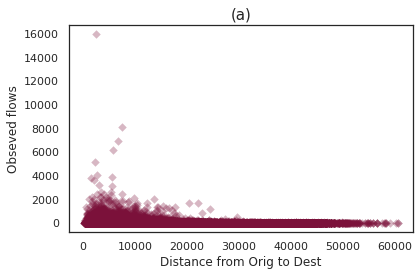

In [55]:
ax = sns.scatterplot(data=final_result,x="distance", y="flows",
                color='#7B113A',marker="D",linewidth=0,alpha=0.3)
ax.set(xlabel = 'Distance from Orig to Dest',
       ylabel = 'Obseved flows')
ax.set_title('(a)',fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P2_flows.jpg'), dpi = 300)

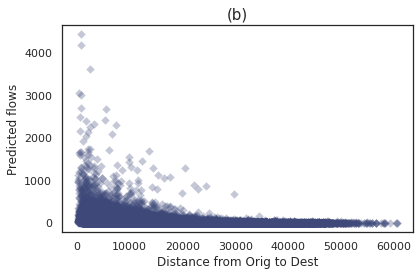

In [56]:
ax = sns.scatterplot(data=final_result,x="distance", y="raw_origsim",
                color='#3E497A',marker="D",linewidth=0,alpha=0.3)
ax.set(xlabel = 'Distance from Orig to Dest',
       ylabel = 'Predicted flows')
ax.set_title('(b)',fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P2_raw_origsim.jpg'), dpi = 300)

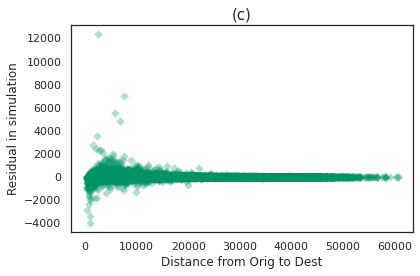

In [57]:
ax = sns.scatterplot(data=final_result,x="distance", y="diff_origsim",
                color='#019267',marker="D",linewidth=0,alpha=0.3)
ax.set(xlabel = 'Distance from Orig to Dest',
       ylabel = 'Residual in simulation')
ax.set_title('(c)',fontsize=15)

plt.tight_layout()
plt.savefig(os.path.join(dirs,'P2_diff_sim.jpg'), dpi = 300)

<AxesSubplot:xlabel='distance', ylabel='diff%_origsim_A'>

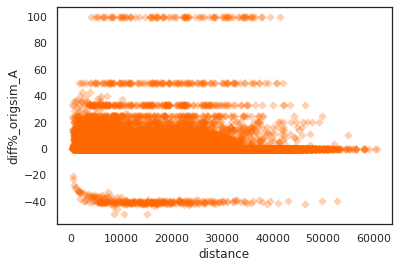

In [58]:
sns.scatterplot(data=final_result,x="distance", y="diff%_origsim_A",
                color='#FF6701',marker="D",linewidth=0,alpha=0.3)

In [59]:
#ax = sns.kdeplot(data=final_result,x="distance", y="diff%_origsim_A",
#                color='#251D3A',levels=5, thresh=.02)

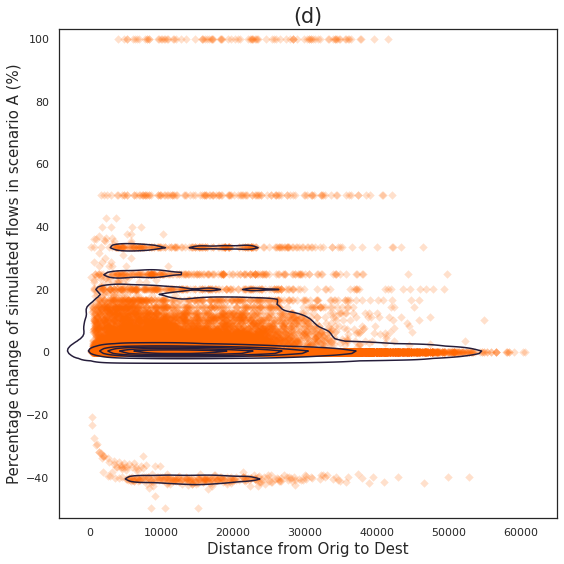

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(data=final_result,x="distance", y="diff%_origsim_A",
                color='#FF6701',marker="D",linewidth=0,alpha=0.2)
ax = sns.kdeplot(data=final_result,x="distance", y="diff%_origsim_A",
                color='#251D3A',levels=7, thresh=.02)
ax.set_xlabel('Distance from Orig to Dest', fontsize = 15)
ax.set_ylabel('Percentage change of simulated flows in scenario A (%)', fontsize = 15)
ax.set_title('(d)',fontsize=20.6)
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P2_A.jpg'), dpi = 300)

<AxesSubplot:xlabel='distance', ylabel='diff%_origsim_B1'>

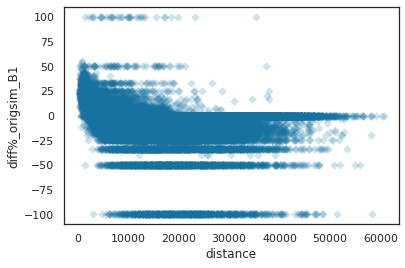

In [61]:
sns.scatterplot(data=final_result,x="distance", y="diff%_origsim_B1",
                color='#1572A1',marker="D",linewidth=0,alpha=0.2)

In [62]:
#ax = sns.kdeplot(data=final_result,x="distance", y="diff%_origsim_B1",
#                color='#251D3A',levels=5, thresh=.02)

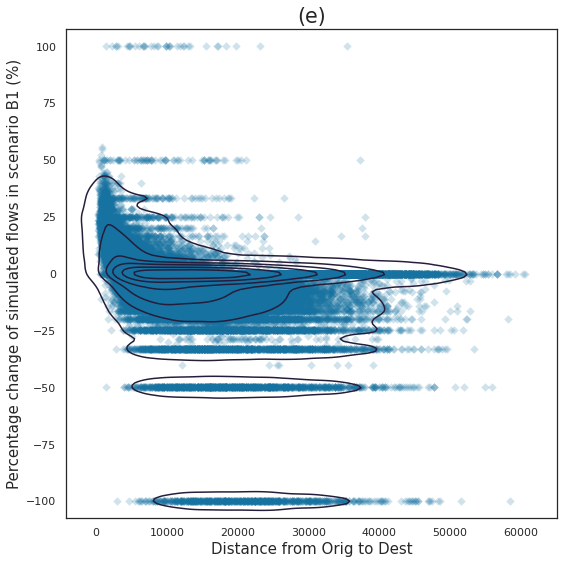

In [63]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(data=final_result,x="distance", y="diff%_origsim_B1",
                color='#1572A1',marker="D",linewidth=0,alpha=0.2)
ax = sns.kdeplot(data=final_result,x="distance", y="diff%_origsim_B1",
                color='#251D3A',levels=7, thresh=.02)
ax.set_xlabel('Distance from Orig to Dest', fontsize = 15)
ax.set_ylabel('Percentage change of simulated flows in scenario B1 (%)', fontsize = 15)
ax.set_title('(e)',fontsize=20.6)

plt.tight_layout()
plt.savefig(os.path.join(dirs,'P2_B1.jpg'), dpi = 300)

<AxesSubplot:xlabel='distance', ylabel='diff%_origsim_B2'>

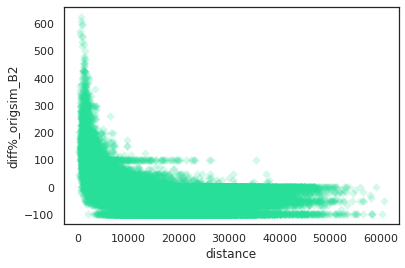

In [64]:
sns.scatterplot(data=final_result,x="distance", y="diff%_origsim_B2",
                color='#28DF99',marker="D",linewidth=0,alpha=0.2)


In [65]:
#ax = sns.kdeplot(data=final_result,x="distance", y="diff%_origsim_B2",
#                color='#251D3A',levels=7, thresh=.02)

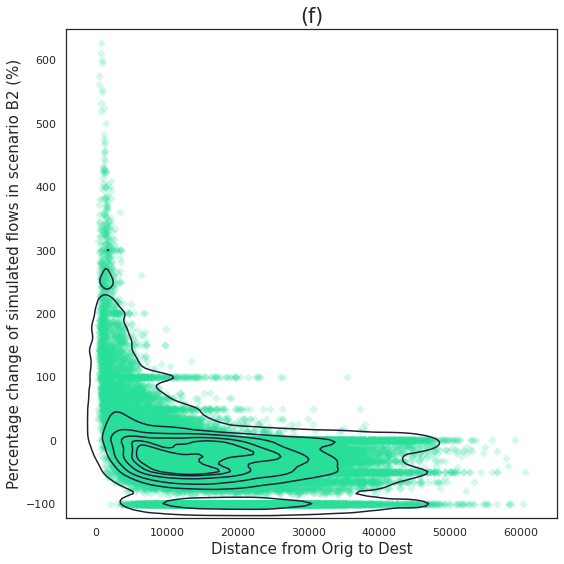

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(data=final_result,x="distance", y="diff%_origsim_B2",
                color='#28DF99',marker="D",linewidth=0,alpha=0.2)
ax = sns.kdeplot(data=final_result,x="distance", y="diff%_origsim_B2",
                color='#251D3A',levels=7, thresh=.02)
ax.set_xlabel('Distance from Orig to Dest', fontsize = 15)
ax.set_ylabel('Percentage change of simulated flows in scenario B2 (%)', fontsize = 15)
ax.set_title('(f)',fontsize=20.6)

plt.tight_layout()
plt.savefig(os.path.join(dirs,'P2_B2.jpg'), dpi = 300)

## Additional attempt

In considerations of completness of the OD matrix, it is better to recompute the OD matrix. Each station could reach and possibly communicate every other station, even though no flow identified from this station to another.

The complete OD matrix should have be 399X398 (excludes self to self), which is up to 158,802 rows. Limited by the Ram size, it is not possible to work on the complete OD matrix, which would easily lead to a died kernel. Although it is successfully to compute athe complete OD matrix, still I decide to use the cleaned dataset rather than complete OD matrix.

It was an attempt to generate the complete OD matrix by the following code. Uncomment to compute.

In [67]:
#list_stations = ODflows_df['Orig'].unique().tolist()

#Orig=[]
#Dest=[]
#for i in list_stations:
#    for j in list_stations:
#        Orig.append(i)
#        Dest.append(j)

#pops=[]
#for station in list_stations:
#    pops.append(ODflows_df[ODflows_df['Orig']==station]['Oi_pop'].unique()[0])
#pop_dict = dict(zip(list_stations,pops))

#jobs=[]
#for station in list_stations:
#    jobs.append(ODflows_df[ODflows_df['Dest']==station]['Dj_jobs'].unique()[0])
#job_dict = dict(zip(list_stations,jobs))

#OD_matrix = pd.DataFrame({
#    'Orig':Orig,
#    'Dest':Dest,
#})
#OD_matrix['combine'] = OD_matrix['Orig']+';'+OD_matrix['Dest']
#ODflows_df['combine'] = ODflows_df['Orig']+';'+ODflows_df['Dest']
#ODflows_df_ = ODflows_df.groupby(['combine'], sort=False)['flows'].sum().reset_index()

#OD_matrix_full = pd.merge(OD_matrix,ODflows_df_,how='left',on=['combine'])

#OD_matrix_full['Orig']=OD_matrix_full['combine'].map(lambda x:x.split(';')[0])
#OD_matrix_full['Dest']=OD_matrix_full['combine'].map(lambda x:x.split(';')[1])
#OD_matrix_full=OD_matrix_full.drop('combine',axis=1)

#OD_matrix_full['Oi_pop'] = OD_matrix_full['Orig'].map(pop_dict)
#OD_matrix_full['Dj_jobs'] = OD_matrix_full['Dest'].map(job_dict)

By observing the distance column in the raw dataset, I found it is generated from shortest_path_length in the undergound network.

In [68]:
#G = nx.read_graphml('london.graph.xml')
#list_distance=[]
#for i in list_stations:
#    for j in list_stations:
#        list_distance.append(nx.shortest_path_length(G,i,j,weight='length'))

#OD_matrix_full['distance'] = list_distance

#list_row = []
#for row in range(len(OD_matrix_full)):
#    if OD_matrix_full['Orig'][row]==OD_matrix_full['Dest'][row]:
#        list_row.append(row)

#OD_matrix_final = OD_matrix_full.drop(list_row,axis=0)

#OD_matrix_final = OD_matrix_final.replace(np.nan,0)
#OD_matrix_final['flows'] = OD_matrix_final['flows'].astype(int)
#OD_matrix_final['log_Dist'] = np.log(OD_matrix_final['distance'])

In [69]:
#OD_matrix_final

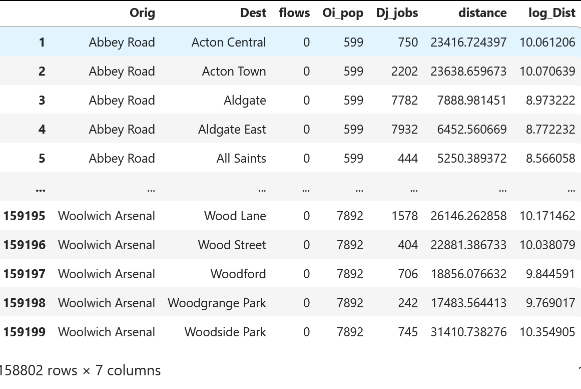